**Note: All the codes are executed on Kaggle's GPU P100 Hardware Accelerator**

We have added some snips from the kaggle notebooks as well for demonstration

GPT-2 was run on other cluster (took help of friend's university GPU)

# Results

|Model|BLEU|ROUGE-1|ROUGE-2|ROUGE-L|
|--|--|--|--|--|
|BART|0.06342|0.3386|0.1278|0.3176|
|Sequence2Sequence (LSTM) |0.1022|0.3790|0.1596|0.3583|
|T5|0.1867|0.4439|0.2413|0.4274|
|GPT-2|0.2269|0.4821|0.2931|0.4669|

# Datasets

## Summarization Dataset

In [ ]:
import pandas as pd
df = pd.read_csv("/kaggle/input/summarization-dataset/summarization_data.csv")
df.head()

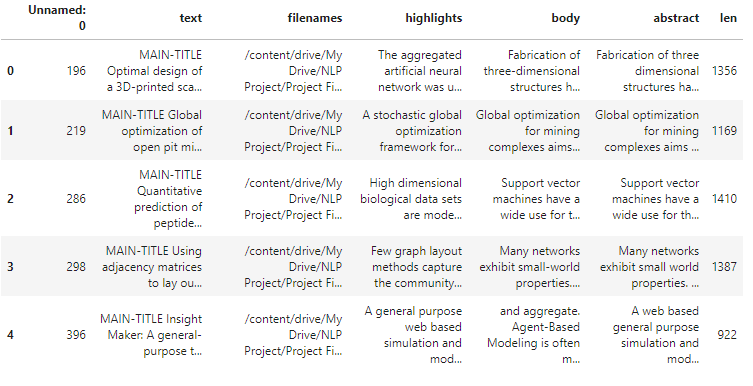

In [ ]:
df= df.iloc[:-100]
test_df = df.iloc[-100:]
#test_df.head()

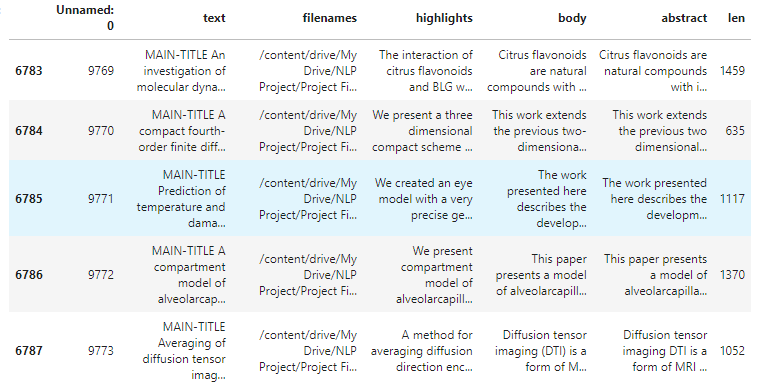

## Lexical Simplification Dataset

In [ ]:
data=pd.read_csv('/kaggle/input/lex-train-final/lex_train_final.csv')
data.head()


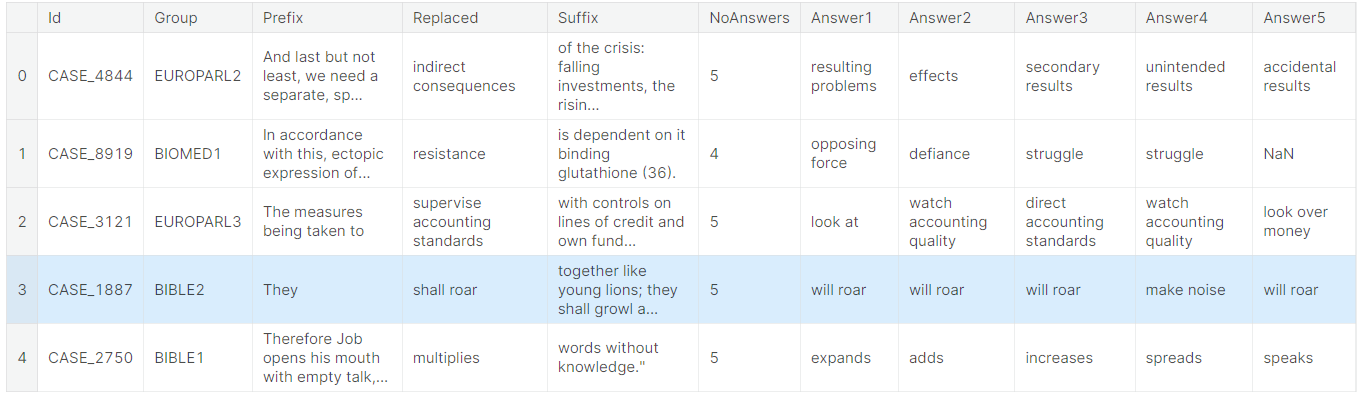

# Preprocessing Dataset

## Summarization Dataset

Preporcessing steps that needs to be done:
1. Remove extra whitespaces in 'highlights', 'body', and 'text' columns.
2. Remove square brackets and numbers from the 'text' column.
3. Extract the 'abstract' from the 'text' column based on the 'ABSTRACT' and 'INTRODUCTION' markers.
4. Filter rows based on the length of the 'abstract' column, keeping only those with lengths between 500 and 2000 characters.
5. Replace URLs in the 'text' column with a specified replacement token ("<LINK>").
6. Strip leading whitespaces from 'abstract' and 'highlights' columns.
7. Remove special characters (excluding alphanumeric characters, whitespace, dots, and hyphens) from 'abstract' and 'highlights' columns.
8. Replace hyphens with spaces in 'abstract' and 'highlights' columns.





In [ ]:

df['highlights'] = df['highlights'].str.replace(r'\s+', ' ')
df['body'] = df['body'].str.replace(r'\s+', ' ')
df['text'] = df['text'].str.replace(r'\s+', ' ')
df['text'] = df['text'].apply(lambda x: re.sub(r'\[\d+\]', '', x))
df['abstract'] = df['text'].apply(lambda x: x.split("ABSTRACT")[1].split("INTRODUCTION")[0])
df['len'] = df['abstract'].str.len()
df = df[df['len'] <= 2000]
df = df[df['len'] >= 500]
replacement_token = "<LINK>"
# Using regular expression to replace URLs with the token in 'text'
df['text'] = df['text'].str.replace(r'https?://\S+', replacement_token, regex=True)
df['abstract'] = df['abstract'].str.lstrip()
df['highlights'] = df['highlights'].str.lstrip()
df['abstract'] = df['abstract'].str.replace(r'[^\w\s.-]', '', regex=True)
df['highlights'] = df['highlights'].str.replace(r'[^\w\s.-]', '', regex=True)
df['abstract'] = df['abstract'].str.replace('-', ' ')
df['highlights'] = df['highlights'].str.replace('-', ' ')

## Lexical Simplification Dataset

In [ ]:
# checking for 'nan' values in 'Prefix', 'Replaced' and 'Suffix' column

null_counts = data.isnull().sum()

# Display the counts
print(null_counts)

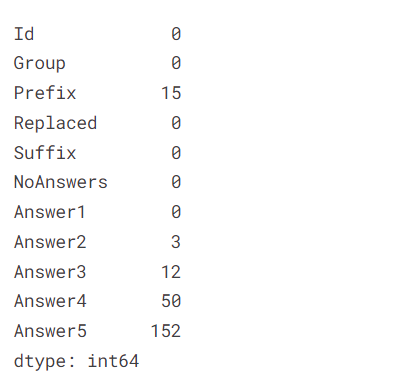

In [ ]:
# we replaced the 'nan' values from the 'Prefix', so that it doesn't interfere in string concatenate operations
data['Prefix'].fillna('', inplace=True)

# Text Simplification

## Text Summarization Modelling

### Seq2Seq LSTM Modelling (Encoder-Decoder Architecture)

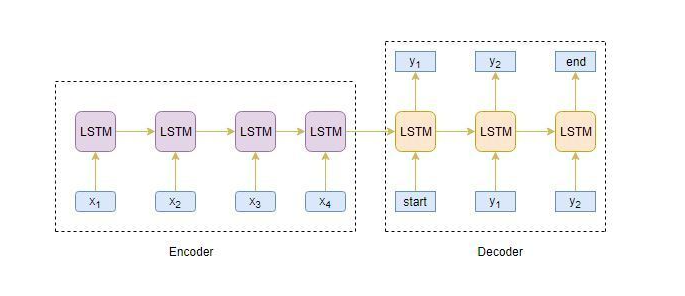

In [ ]:
# Here we will add Start of Sentence Token and End of Sentence Token for model to understand start and stop generating the summary
df['summary']= df['highlights']
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['abstract']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#preparing a tokenizer for training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

In [ ]:
max_text_len=500
max_summary_len=150

#prepare a tokenizer for  training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

In [ ]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

In [ ]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)


In [ ]:
# Finding and deleting all short length summaries
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [ ]:
from keras import backend as K
import gensim
from numpy import *
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

print("Size of vocabulary from the w2v model = {}".format(x_voc))

K.clear_session()

latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

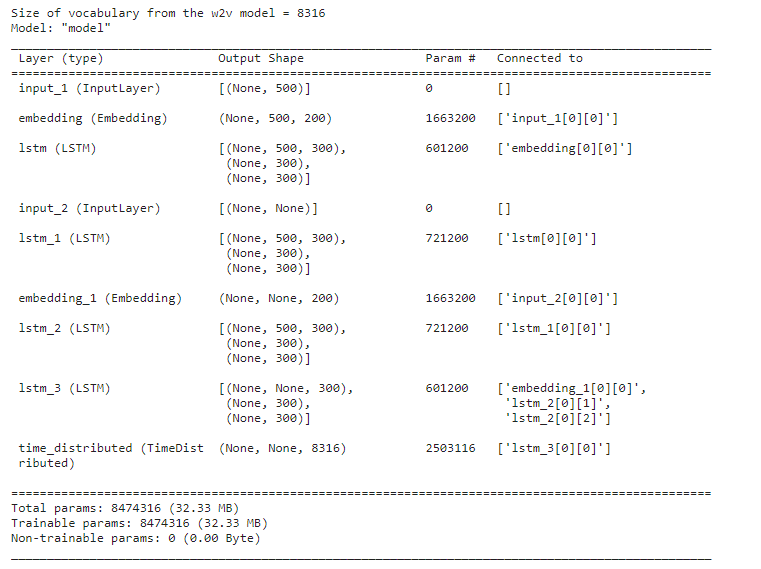

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

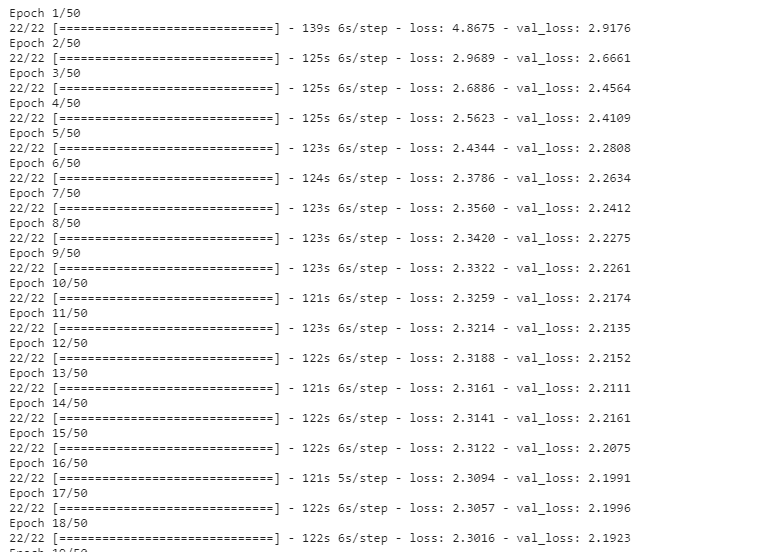

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
import pandas as pd

# Lists to store results
reviews = []
original_summaries = []
predicted_summaries = []

for i in range(100):
    review = seq2text(x_tr[i])
    original_summary = seq2summary(y_tr[i])
    predicted_summary = decode_sequence(x_tr[i].reshape(1, max_text_len))

    reviews.append(review)
    original_summaries.append(original_summary)
    predicted_summaries.append(predicted_summary)

# Create DataFrame
df_results = pd.DataFrame({
    'Review': reviews,
    'Original Summary': original_summaries,
    'Predicted Summary': predicted_summaries
})

# Display the DataFrame
df_results.to_csv("LSTM.csv")
df_results.head()


### BART (Bidirectional and Auto-Regressive Transformer)
**Encoder-Decoder Architecture**

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BartTokenizer, BartForConditionalGeneration

# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn').to(device)


# Tokenize and prepare data
tokenized_documents = tokenizer(df['abstract'].tolist(), return_tensors='pt', padding=True, truncation=True)
tokenized_summaries = tokenizer(df['highlights'].tolist(), return_tensors='pt', padding=True, truncation=True)

input_ids = tokenized_documents['input_ids'].to(device)
target_ids = tokenized_summaries['input_ids'].to(device)

# Prepare DataLoader
dataset = TensorDataset(input_ids, target_ids)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

from tqdm import tqdm
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# Training loop with tqdm
num_epochs = 5
for epoch in range(num_epochs):
    total_loss = 0.0
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f'Epoch {epoch + 1}/{num_epochs}', position=0, leave=True)

    for step, batch in progress_bar:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, labels=targets)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Update tqdm description with current loss
        progress_bar.set_postfix(loss=total_loss / (step + 1))

    average_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {average_loss:.4f}")

# Save the fine-tuned model
model.save_pretrained('fine_tuned_summarization_model')

In [ ]:
tokenizer.save_pretrained('fine_tuned_summarization_model/tokenizer')

from transformers import BartTokenizer, BartForConditionalGeneration
model = BartForConditionalGeneration.from_pretrained('fine_tuned_summarization_model').to(device)
tokenizer = BartTokenizer.from_pretrained('fine_tuned_summarization_model/tokenizer')


In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset


if 'abstract' not in test_df.columns:
    raise ValueError("Test set does not have the 'abstract' column.")

tokenized_test_input = tokenizer(test_df['abstract'].tolist(), return_tensors='pt', padding=True, truncation=True)
test_input_ids = tokenized_test_input['input_ids']

test_dataset = TensorDataset(test_input_ids)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)

predictions = []
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for batch in test_dataloader:
        inputs = batch[0].to(device)
        outputs = model.generate(inputs, max_length=50, num_beams=4, length_penalty=2.0, early_stopping=True)
        decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        predictions.extend(decoded_outputs)

# Adding predictions to the test dataframe
test_df['predicted_highlights'] = predictions







1.   Each epoch took 22.45 minutes to train
2.   We trained model for 5 epochs
3.   The model was predicted the same text with noise added to model which was very poor  result



### T5 Model

In [ ]:
import pandas as pd
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW

# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained T5 model and tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small').to(device)


# Tokenize and prepare data
tokenized_input = tokenizer(df['abstract'].tolist(), return_tensors='pt', padding=True, truncation=True)
tokenized_target = tokenizer(df['highlights'].tolist(), return_tensors='pt', padding=True, truncation=True)

input_ids = tokenized_input['input_ids']
labels = tokenized_target['input_ids']  # T5 uses the 'labels' parameter for target sequence

# Prepare DataLoader
dataset = TensorDataset(input_ids, labels)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0.0
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f'Epoch {epoch + 1}/{num_epochs}', position=0, leave=True)

    for step, batch in progress_bar:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = model(inputs, labels=targets)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=total_loss / (step + 1))

    average_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {average_loss:.4f}")

# Save the fine-tuned model
model.save_pretrained('fine_tuned_summarization_t5')
tokenizer.save_pretrained('fine_tuned_summarization_t5/tokenizer')


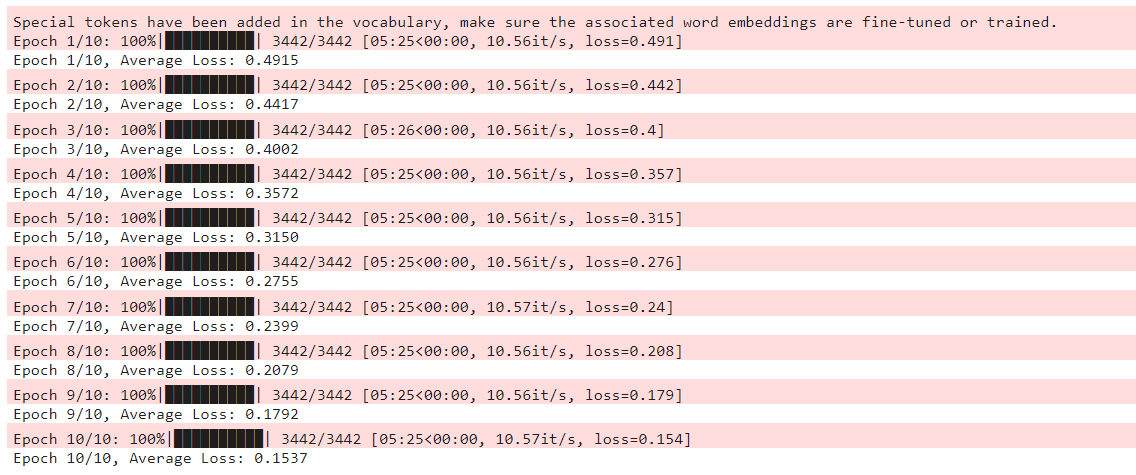

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load fine-tuned T5 model and tokenizer
model = T5ForConditionalGeneration.from_pretrained('fine_tuned_summarization_t5').to(device)
tokenizer = T5Tokenizer.from_pretrained('fine_tuned_summarization_t5/tokenizer')

# Assuming 'test_df' is your test dataset
# Ensure that the 'abstract' column exists in the test set
if 'abstract' not in test_df.columns:
    raise ValueError("Test set does not have the 'abstract' column.")

# Tokenize and prepare test data
tokenized_test_input = tokenizer(test_df['abstract'].tolist(), return_tensors='pt', padding=True, truncation=True)
test_input_ids = tokenized_test_input['input_ids']

# Prepare DataLoader for test data
test_dataset = TensorDataset(test_input_ids)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# Make predictions on the test set
predictions = []
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for batch in test_dataloader:
        inputs = batch[0].to(device)
        outputs = model.generate(inputs, max_length=128, num_beams=4, length_penalty=2.0, early_stopping=True)
        decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        predictions.extend(decoded_outputs)

# Add predictions to the test dataframe
test_df['predicted_highlights'] = predictions





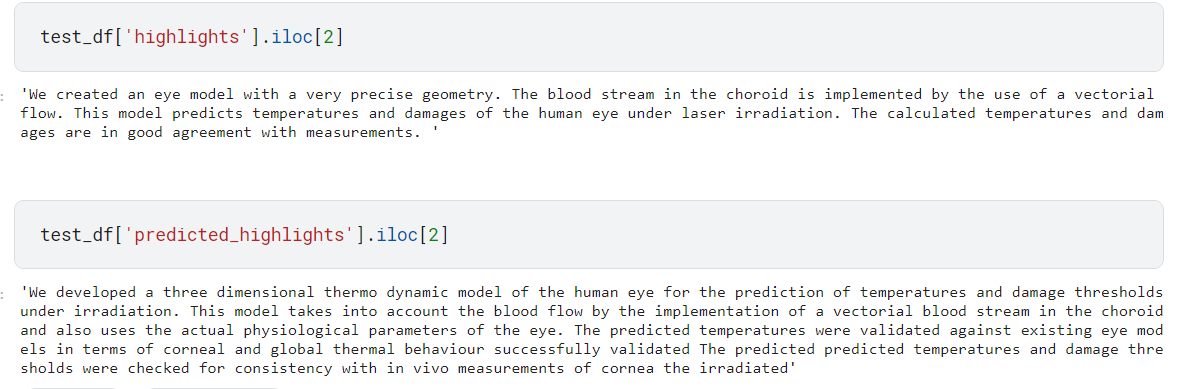

### GPT 2 (Decoder Only Model) For summarization task

**Credits**

This code has been understood and changed for our task with the help of following sources:

1) https://blog.paperspace.com/generating-text-summaries-gpt-2/

2) https://github.com/SKRohit/Generating_Text_Summary_With_GPT2


In [ ]:
import argparse
from datetime import datetime
import os
import time

import numpy as np
from transformers import GPT2LMHeadModel,AdamW
from torch.utils.tensorboard import SummaryWriter
import torch
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from tqdm import tnrange, tqdm_notebook
from transformers.optimization import get_linear_schedule_with_warmup
import random
import numpy as np
import torch
import torch.nn.functional as F
from transformers import GPT2Tokenizer
from tqdm import tnrange



In [ ]:
def add_special_tokens():
	""" Returns GPT2 tokenizer after adding separator and padding tokens """
	tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
	special_tokens = {'pad_token':'<|pad|>','sep_token':'<|sep|>'}
	num_add_toks = tokenizer.add_special_tokens(special_tokens)
	return tokenizer

def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)


def top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=-float('Inf')):
    assert logits.dim() == 1  # batch size 1 for now - could be updated for more but the code would be less clear
    top_k = min(top_k, logits.size(-1))  # Safety check
    if top_k > 0:
        # Removes all tokens with a probability less than the last token of the top-k
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p > 0.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        # Remove tokens with cumulative probability above the threshold
        sorted_indices_to_remove = cumulative_probs > top_p
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        logits[indices_to_remove] = filter_value
    return logits


def sample_seq(model, context, length, device, temperature=1, top_k=0, top_p=0.0):
    context = torch.tensor(context, dtype=torch.long, device=device)
    context = context.unsqueeze(0)
    generated = context
    with torch.no_grad():
        for _ in tnrange(length):
            inputs = {'input_ids': generated}
            outputs = model(**inputs)  # Note: we could also use 'past' with GPT-2/Transfo-XL/XLNet (cached hidden-states)
            next_token_logits = outputs[0][0, -1, :] / temperature
            filtered_logits = top_k_top_p_filtering(next_token_logits, top_k=top_k, top_p=top_p)
            next_token = torch.multinomial(F.softmax(filtered_logits, dim=-1), num_samples=1)
            generated = torch.cat((generated, next_token.unsqueeze(0)), dim=1)
    return generated


def beam_search(model, context, length, beam_size, device, temperature=1):
    context = torch.tensor(context, dtype=torch.long, device=device)
    context = context.unsqueeze(0)
    with torch.no_grad():
        inputs = {'input_ids': context}
        outputs = model(**inputs)
        next_token_logits = outputs[0][0, -1, :] / temperature
        next_token_probs = F.softmax(next_token_logits)
        scores, indices = torch.topk(next_token_probs, beam_size)
        indices = indices.tolist()
        sequences = [[c] for c in indices]
        for _ in tnrange(length-1):
            logits = torch.zeros(beam_size*len(next_token_logits))
            for j in range(len(sequences)):
                new_generated = torch.cat((context,torch.tensor([sequences[j]], dtype=torch.long, device=device)),dim=1)
                inputs = {'input_ids': new_generated}
                outputs = model(**inputs)
                next_token_logits = outputs[0][0, -1, :] / temperature
                next_token_probs = F.softmax(next_token_logits)
                start, stop = j*len(next_token_logits), (j+1)*len(next_token_logits)
                logits[start:stop] = scores[j]*next_token_probs
            scores, new_logits_indices = torch.topk(logits,beam_size)
            logits = (new_logits_indices%50259).tolist()
            for j in range(len(sequences)):
                sequences[j] = sequences[j]+[logits[j]]
    return scores, sequences


def generate_beam_sample(data, tokenizer, model, num=1, length=100, beam_size=3, device=torch.device('cuda')):

    for i in range(num):
        sample = data[i]
        idx = sample['sum_idx']
        context = sample['article'][:idx].tolist()
        summary = sample['article'][idx+1:][:100].tolist()
        scores, sequences = beam_search(model, context, length, beam_size, device)
        print('new_article', end='\n\n')
        print(tokenizer.decode(context[:-1]), end='\n\n')
        print('actual_summary', end='\n\n')
        print(tokenizer.decode(summary), end='\n\n')
        for i in range(len(sequences)):
            text = tokenizer.convert_ids_to_tokens(sequences[i],skip_special_tokens=True)
            text = tokenizer.convert_tokens_to_string(text)
            print("generated_summary-{} and Score is {}.".format(i+1, scores[i]), end='\n\n')
            print(text, end='\n\n')


def generate_sample(data, tokenizer, model, num=1, eval_step=False, length=100, temperature=1, top_k=10, top_p=0.5, device=torch.device('cuda')):

    for i in range(num):
        sample = data[i]
        idx = sample['sum_idx']
        context = sample['article'][:idx].tolist()
        summary = sample['article'][idx+1:][:100].tolist()
        generated_text = sample_seq(model, context, length, device, temperature, top_k, top_p)
        generated_text = generated_text[0, len(context):].tolist()
        text = tokenizer.convert_ids_to_tokens(generated_text,skip_special_tokens=True)
        text = tokenizer.convert_tokens_to_string(text)
        if eval_step==False:
            print('new_article', end='\n\n')
            print(tokenizer.decode(context), end='\n\n')
            print("generated_summary", end='\n\n')
            print(text, end='\n\n')
            print('actual_summary', end='\n\n')
            print(tokenizer.decode(summary), end='\n\n')
        else:
            print(tokenizer.decode(context), end='\n\n')
            print("generated_summary", end='\n\n')

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument("--lr",default=5e-5, type=float, help="learning rate")
parser.add_argument("--seed",default=42, type=int,  help="seed to replicate results")
parser.add_argument("--n_gpu",default=1, type=int,  help="no of gpu available")
parser.add_argument("--gradient_accumulation_steps",default=2, type=int, help="gradient_accumulation_steps")
parser.add_argument("--batch_size",default=1, type=int,  help="batch_size")
parser.add_argument("--num_workers",default=4, type=int,  help="num of cpus available")
parser.add_argument("--device",default=torch.device('cpu'), help="torch.device object")
parser.add_argument("--num_train_epochs",default=1, type=int,  help="no of epochs of training")
parser.add_argument("--output_dir",default='./output', type=str,  help="path to save evaluation results")
parser.add_argument("--model_dir",default='./weights', type=str,  help="path to save trained model")
parser.add_argument("--max_grad_norm",default=1.0, type=float, help="max gradient norm.")
parser.add_argument("--root_dir",default='./CNN/gpt2_1024_data', type=str, help="location of json dataset.")
parser.add_argument("--ids_file",default='./CNN/ids.json', type=str, help="location of train, valid and test file indexes")
args = parser.parse_args([])
print(args)

In [ ]:
def train(args, model, tokenizer, train_dataset, valid_dataset, ignore_index):
    writer = SummaryWriter('./output/logs')
    train_sampler = RandomSampler(train_dataset)
    train_dl = DataLoader(train_dataset,sampler=train_sampler,batch_size=args.batch_size,num_workers=args.num_workers)
    loss_fct = CrossEntropyLoss(ignore_index=ignore_index) #ignores padding token for loss calculation
    optimizer = AdamW(model.parameters(),lr=args.lr)
    scheduler = get_linear_schedule_with_warmup(optimizer,100,80000)

    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = tnrange(int(args.num_train_epochs), desc="Epoch")
    set_seed(args)
    for _ in train_iterator:
        epoch_iterator = tqdm_notebook(train_dl, desc="Training")
        for step, batch in enumerate(epoch_iterator):
            inputs, labels = batch['article'].to(args.device), batch['article'].to(args.device)
            model.train()
            logits = model(inputs)[0]
            # only consider loss on reference summary just like seq2seq models
            shift_logits = logits[..., batch['sum_idx']:-1, :].contiguous()
            shift_labels = labels[..., batch['sum_idx']+1:].contiguous()
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            loss = loss/args.gradient_accumulation_steps
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1
                writer.add_scalar('lr', scheduler.get_lr()[0], global_step)
                writer.add_scalar('loss', (tr_loss - logging_loss)/args.gradient_accumulation_steps, global_step)
                logging_loss = tr_loss
                print("loss:", loss.item(), end='\n\n')
                if (step + 1)/args.gradient_accumulation_steps == 1.0:
                	print('After 1st update: ', end='\n\n')
                	generate_sample(valid_dataset, tokenizer, model, num=2, eval_step=False,device=args.device)


            if (step + 1) % (10*args.gradient_accumulation_steps) == 0:
                results = evaluate(args, model, valid_dataset, ignore_index, global_step)
                for key, value in results.items():
                    writer.add_scalar('eval_{}'.format(key), value, global_step)
                print('After', global_step+1,'updates: ', end='\n\n')
                generate_sample(valid_dataset, tokenizer, num=2, eval_step=True,device=args.device)

In [ ]:
def evaluate(args, model, eval_dataset, ignore_index, global_step=None):
    if not os.path.exists(args.output_dir):
        os.mkdir(args.output_dir)
    eval_output_dir = args.output_dir

    results = {}
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args.batch_size)
    loss_fct = CrossEntropyLoss(ignore_index=ignore_index) #ignores padding token for loss calculation

    eval_loss = 0.0
    nb_eval_steps = 0
    model.eval()

    for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):
        inputs, labels = batch['article'].to(args.device), batch['article'].to(args.device)

        with torch.no_grad():
            logits = model(inputs)[0]
            idx = batch['sum_idx'].item() # index of separator token
            # only consider loss on reference summary just like seq2seq models
            shift_logits = logits[..., batch['sum_idx']:-1, :].contiguous()
            shift_labels = labels[..., batch['sum_idx']+1:].contiguous()
            lm_loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            eval_loss += lm_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    perplexity = torch.exp(torch.tensor(eval_loss))

    result = {
        "perplexity": perplexity
    }
    print("perplexity:", perplexity.item())

    if global_step:
        output_eval_file = os.path.join(eval_output_dir, "eval_results.txt")
        with open(output_eval_file, "a") as f:
            for key in sorted(result.keys()):
                f.write('\n\n')
                f.write("time = %s, %s = %s, step = %s\n" % (datetime.now().strftime("%d/%m/%Y %H:%M:%S"), key, str(result[key]), str(global_step)))
    return resul

In [ ]:
import torch
from torch.utils.data import Dataset
from transformers import GPT2Tokenizer

class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_input_length=512, max_target_length=150):
        print("yes")
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        abstract = self.data['abstract'].iloc[index]
        highlights = self.data['highlights'].iloc[index]
        print(abstract)
        # Tokenize input and target
        input_ids = self.tokenizer.encode(abstract, max_length=self.max_input_length, truncation=True, padding='max_length', return_tensors='pt')
        target_ids = self.tokenizer.encode(highlights, max_length=self.max_target_length, truncation=True, padding='max_length', return_tensors='pt')

        return {
            'input_ids': input_ids.squeeze(),
            'labels': target_ids.squeeze(),
        }

In [ ]:
train_dataset = CustomDataset(df.iloc[:609], tokenizer)
valid_dataset = CustomDataset(df.iloc[-100:], tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)
valid_dataloader = DataLoader(valid_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)

tokenizer = add_special_tokens()
ignore_idx = tokenizer.pad_token_id
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.resize_token_embeddings(len(tokenizer))
model.to(args.device)



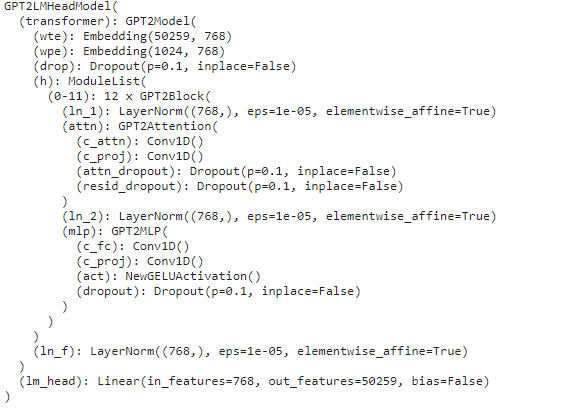

In [ ]:
# Prediction on test set

if 'abstract' not in test_df.columns:
    raise ValueError("Test set does not have the 'abstract' column.")

# Tokenize and prepare test data
tokenized_test_input = tokenizer(test_df['abstract'].tolist(), return_tensors='pt', padding=True, truncation=True)
test_input_ids = tokenized_test_input['input_ids']

# Prepare DataLoader for test data
test_dataset = TensorDataset(test_input_ids)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# Make predictions on the test set
predictions = []
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for batch in test_dataloader:
        inputs = batch[0].to(device)
        outputs = model.generate(inputs, max_length=150, num_beams=4, length_penalty=2.0, early_stopping=True)
        decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        predictions.extend(decoded_outputs)

# Add predictions to the test dataframe
test_df['predicted_highlights1'] = predictions

## Lexicon Simplification

### Installing Dependencies

In [ ]:
!pip install torch torchvision transformers

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm

### T5 Modelling

In [ ]:
# importing T5 tokenizer
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [ ]:
# Split the data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.1, random_state=42)

In [ ]:
# function for tokenizing the input data
class SimplificationDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        try:

            source_sentence = item['Prefix'] + ' ' + item['Replaced'] + ' ' + item['Suffix']
            target_sentence = item['Prefix'] + ' ' + item['Answer1'] + ' ' + item['Suffix'] # Assuming you want to use the first replacement as the target

        except TypeError as e:
            print(item['Prefix']," || ",item['Replaced'],"|| ",item['Suffix'])
            print(f"Caught a TypeError: {e}")

        source_tokenized = self.tokenizer.encode_plus(
            source_sentence,
            max_length=256,
            padding='max_length',
            return_tensors='pt',
            truncation=True
        )

        target_tokenized = self.tokenizer.encode_plus(
            target_sentence,
            max_length=256,
            padding='max_length',
            return_tensors='pt',
            truncation=True
        )

        return {
            'input_ids': source_tokenized['input_ids'].squeeze(),
            'attention_mask': source_tokenized['attention_mask'].squeeze(),
            'labels': target_tokenized['input_ids'].squeeze()
        }

tokenizer = T5Tokenizer.from_pretrained('t5-base')
train_dataset = SimplificationDataset(train_data, tokenizer)
val_dataset = SimplificationDataset(val_data, tokenizer)

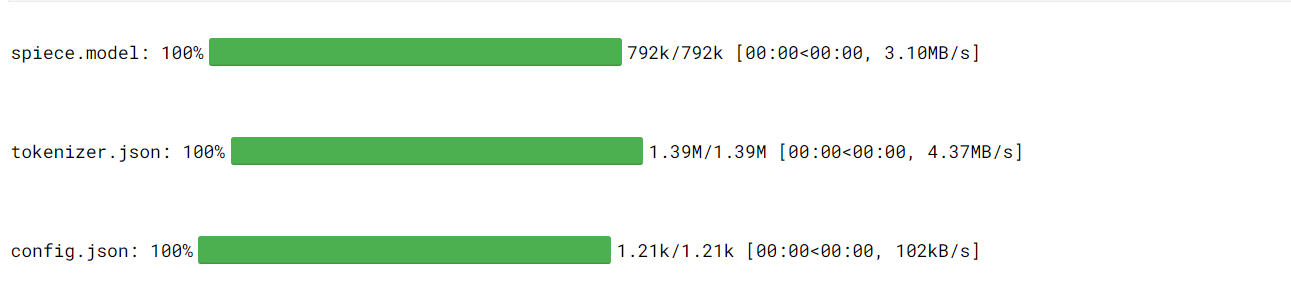

In [ ]:
# loading gpu, model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = T5ForConditionalGeneration.from_pretrained('t5-base').to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [ ]:
# training loop
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}, Training Loss: {average_loss}')

    # Validation
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f'Validation Epoch {epoch + 1}'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

    average_val_loss = total_val_loss / len(val_dataloader)
    print(f'Validation Loss: {average_val_loss}')

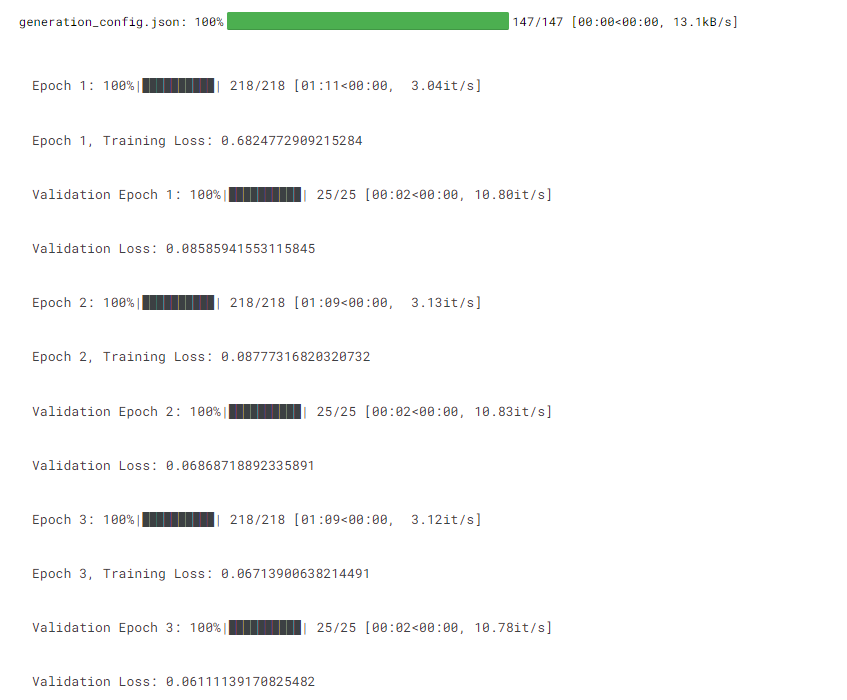

In [ ]:
# After training this model on the above lexical simplification dataset, we will make predictions to do lexical simplification on our original dataset
# loading our original dataset
dx = pd.read_csv('/kaggle/input/summarization-dataset/summarization_data.csv')
dx.head()

In [ ]:
test_df= dx.iloc[-100:]
test_df

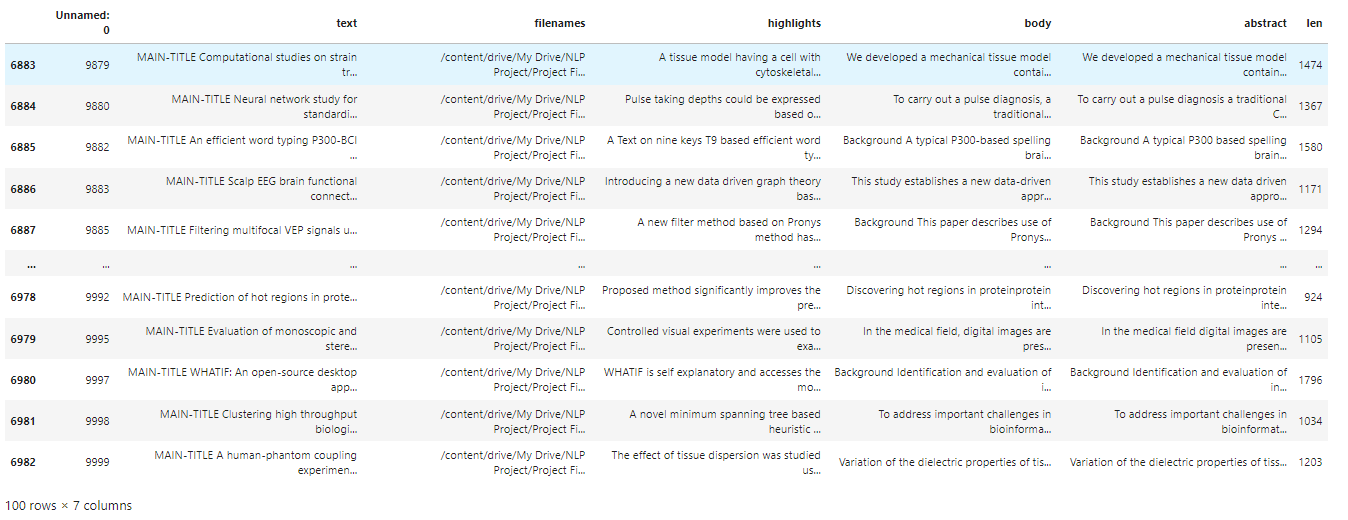

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
if 'abstract' not in test_df.columns:
    raise ValueError("Test set does not have the 'abstract' column.")

# Tokenize and prepare test data
tokenized_test_input = tokenizer(test_df['abstract'].tolist(), return_tensors='pt', padding=True, truncation=True)
test_input_ids = tokenized_test_input['input_ids']

# Prepare DataLoader for test data
test_dataset = TensorDataset(test_input_ids)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# Make predictions on the test set
predictions = []
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for batch in test_dataloader:
        inputs = batch[0].to(device)
        outputs = model.generate(inputs, max_length=150, num_beams=4, length_penalty=2.0, early_stopping=True)
        decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        predictions.extend(decoded_outputs)

# Add predictions to the test dataframe
test_df['predicted_highlights1'] = predictions

In [ ]:
test_df['predicted_highlights1'].iloc[0]

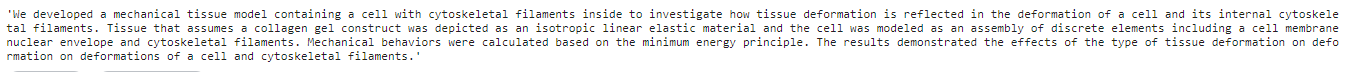

In [ ]:
test_df['abstract'].iloc[0]

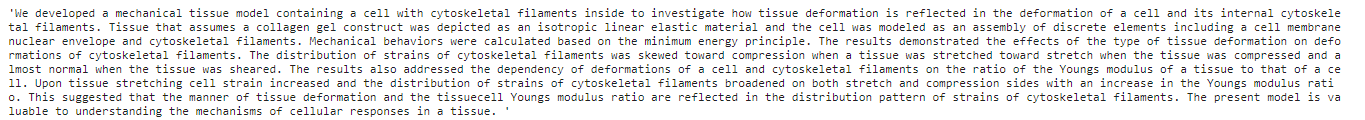

### BERT Modelling

In [ ]:
# importing tokenizer for BERT
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

In [ ]:
model_name = 'bert-base-uncased'

# Initialize the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=1)  # Binary classification (1 label for simplification)


In [ ]:
# Define a custom dataset class
class SimplificationDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        #self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        input_text = item['Prefix'] + ' '+ item['Replaced'] + ' ' + item['Suffix']
        target_text = item['Prefix'] + ' '+ item['Answer1'] + ' ' + item['Suffix']

        # Tokenize input and target sentences
        input_ids = self.tokenizer.encode(input_text, max_length=256, truncation=True, padding='max_length', return_tensors='pt')
        target_ids = self.tokenizer.encode(target_text, max_length=256, truncation=True, padding='max_length', return_tensors='pt')

        return {
            'input_ids': input_ids.squeeze(),
            'labels': target_ids.squeeze()
        }

# Create instances of the dataset
dataset = SimplificationDataset(data, tokenizer)

In [ ]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [ ]:
# Define DataLoader for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [ ]:
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
# Define training parameters
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 3

In [ ]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    # Iterate over training batches
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss  # loss= outputs.loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    # Calculate average training loss for the epoch
    average_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Training Loss: {average_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Validation"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            val_loss += loss.item()

    # Calculate average validation loss for the epoch
    average_val_loss = val_loss / len(val_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Validation Loss: {average_val_loss:.4f}")

# Save the trained model
model.save_pretrained('bert_simplification_model')
tokenizer.save_pretrained('bert_simplification_model')